## René Parlange, MSc
### 📚 Gravitational Lensing Course, PhD in Computer Science
#### 🎓 Instructors: *Dr*. Octavio Valenzuela (IA-UNAM), Dr. Juan Carlos Cuevas (UASLP) and Dr. Omar Cabrera (IA-UNAM)
#### 🏛 Universidad Autónoma de San Luis Potosí (UASLP)

🔗 [GitHub Repository](https://github.com/parlange/gravitational-lensing)



In this example, we implement the calculation of the deflection angle field by an
extended lens **bold text**.

A two-dimensional map of the lens surface density is provided by the
fits file **kappa_2.fits**. The map was obtained by projecting the mass distribution
of a dark matter halo obtained from an N-body simulation (Meneghetti et al. 2017).

To be precise, this is the surface density divided by a constant which depends on
the lens and source redshifts (we will talk about this constant in the next chapter).
This quantity is called *convergence*, κ.

As we pointed out in Sect. 2.4, this integral is a convolution. In Fourier Space, it
becomes a multiplication.

We consider a **convergence map** of *npix* × *npix* pixels, i.e. the function to be
convolved is sampled at a certain number of positions on a regular grid, where the
pixel on the m-th row and n-th column is identified with the couple of indices (m, n).
We will use **Discrete Fourier Transforms (DFTs)** to implement the convolution.

A common algorithm to compute **DFTs** is the socalled **Fast Fourier Transform (FFT)** algorithm (Cooley and Tukey 1965), which
is implemented in many python packages. Here, we use the **numpy.fft** module:

In [9]:
import numpy as np
import numpy.fft as fftengine

To deal with **lenses described by convergence maps**, we define a class called
**deflector**. This class, shown here below, contains some methods that will be
described in detail later.

This class, shown here below, contains some methods that will be
described in detail later. They allow to:

• build the kernel K(x)

• compute the deflection angle map by convolving the convergence with the kernel

• perform the so-called zero-padding

• crop the zero-padded maps

We initialize a deflector object by reading the fits file containing the lens
convergence map. For this purpose, we import the astropy.io.fits module.

In [28]:
import astropy.io.fits as pyfits

class deflector(object):
    """
    initialize the deflector using a surface density (convergence) map
    the boolean variable pad indicates whether zero-padding is used
    or not
    """
    def __init__(self,filekappa,pad=False):
        kappa,header=pyfits.getdata(filekappa,header=True)
        self.kappa=kappa
        self.nx=kappa.shape[0]
        self.ny=kappa.shape[1]
        self.pad=pad
        if (pad):
            self.kpad()
        self.kx,self.ky=self.kernel()

    """
    implement the kernel function K
    """
    def kernel(self):
        x=np.linspace(-0.5,0.5,self.kappa.shape[0])
        y=np.linspace(-0.5,0.5,self.kappa.shape[1])
        kx,ky=np.meshgrid(x,y)
        norm=(kx**2+ky**2+1e-12)
        kx=kx/norm
        ky=ky/norm
        return(kx,ky)
        """
        compute the deflection angle maps by convolving
        the surface density with the kernel function
        Note that the returned values will be in pixel units
        """
    def angles(self):
        # FFT of the surface density and of the two components of the
        # kernel
        kappa_ft = fftengine.rfftn(self.kappa,axes=(0,1))
        kernelx_ft = fftengine.rfftn(self.kx,axes=(0,1), s=self.kappa.shape)
        kernely_ft = fftengine.rfftn(self.ky,axes=(0,1), s=self.kappa.shape)
        # perform the convolution in Fourier space and transform the result
        # back in real space. Note that a shift needs to be applied using
        # fftshift
        alphax = 1.0/np.pi*\
                fftengine.fftshift(fftengine.irfftn(kappa_ft*kernelx_ft))
        alphay = 1.0/np.pi*\
                fftengine.fftshift(fftengine.irfftn(kappa_ft*kernely_ft))
        return(alphax,alphay)
    """
    returns the surface-density (convergence) of the deflector
    """
    def kmap(self):
        return(self.kappa)
    """
    performs zero-padding
    """
    def kpad(self):
        # add zeros around the original array
        def padwithzeros(vector, pad_width, iaxis, kwargs):
            vector[:pad_width[0]] = 0
            vector[-pad_width[1]:] = 0
            return vector
        # use the pad method from numpy.lib to add zeros (padwithzeros)
        # in a frame with thickness self.kappa.shape[0]
        self.kappa=np.lib.pad(self.kappa, self.kappa.shape[0],
            padwithzeros)
    """
    crop the maps to remove zero-padded areas and get back to the
    original region.
    """
    def mapCrop(self,mappa):
        xmin=np.int(0.5*(self.kappa.shape[0]-self.nx))
        ymin=np.int(0.5*(self.kappa.shape[1]-self.ny))
        xmax=xmin+self.nx
        ymax=ymin+self.ny
        mappa=mappa[xmin:xmax,ymin:ymax]
        return(mappa)

We begin by building a deflector and using it to compute the deflection angles
employing the method angles:

In [26]:
df=deflector('kappa_2.fits')
#df=deflector('kappa_gl.fits')
angx_nopad,angy_nopad=df.angles()
kappa=df.kmap()

The function **kmap** returns the *convergence map read from the fits file* as a **numpy
array**. We visualize this map and the maps of the two components of the deflection
angles as in Fig. 2.4 using the following instructions:

Text(0.5, 1.0, 'angle 2')

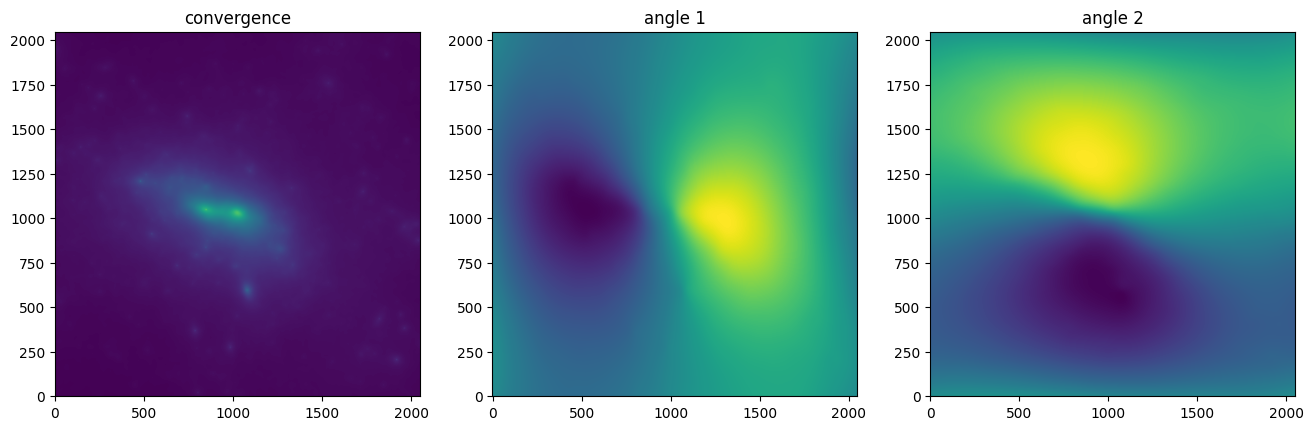

In [27]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,3,figsize=(16,8))
ax[0].imshow(kappa,origin="lower")
ax[0].set_title('convergence')
ax[1].imshow(angx_nopad,origin="lower")
ax[1].set_title('angle 1')
ax[2].imshow(angy_nopad,origin="lower")
ax[2].set_title('angle 2')

Note that, when creating the instance df of deflector, we did not change
the default value of the keyword pad, which is then set to False. Now we
explain the usage of this keyword. The **computation of the DFTs assumes periodic
boundary conditions**. In other words, we can imagine that the **lens mass distribution
is replicated** outside the boundaries of the map **indefinitely** and **periodically**.

Other identical lenses virtually surround the lens, and each of them contributes to the
light deflection. Given that the region around the lens considered in this example is
relatively small, we expect that the deflection angles will be biased near the borders,
where light rays can feel the pull of the mass outside the map.

The three panels in
Fig. 2.4 show the maps of the convergence and the two components of the deflection
angles obtained with this setting

To mitigate this bias, we can use a method called **zero-padding**. Zero-padding
consists of creating a **buffer all around the convergence map, where the convergence
is set to zero**. By doing so, we *increase the size of the original map*, but we expect
to **increase the accuracy of the calculations near the borders**, because the periodic
conditions are better reproduced in this setting **bold text**. We activate zero-padding by setting
the variable pad=True when initializing the deflector. Then, the function kpad
does the job:

In [29]:
ddf=deflector('kappa_2.fits',pad=True)
angx,angy=df.angles()
kappa=df.kmap()

In the example shown in Fig. 2.5, we zealously increase the size of the map by a
factor of 3 in each dimension. We are not interested in this large, zero-padded area,
thus we can get rid of the values outside the footprint of the original convergence
map by using the function mapCrop:

In [30]:
angx=df.mapCrop(angx)
angy=df.mapCrop(angy)

<ipython-input-12-79050e1cb1a7>:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xmin=np.int(0.5*(self.kappa.shape[0]-self.nx))
<ipython-input-12-79050e1cb1a7>:73: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in Num

We show the cropped deflection angle maps in the upper panels of Fig. 2.6. For
comparison, we also show the maps obtained without zero-padding in the bottom panels. As expected, we see that the maps differ significantly along the borders. It is
imperative to perform zero-padding when using the method outlined in this example
to calculate the deflection angles.